In [6]:
from CoLoRe_corrf_analysis.plot_methods import Plots
from CoLoRe_corrf_analysis.file_funcs import FileFuncs
from CoLoRe_corrf_analysis.fitter import Fitter
from CoLoRe_corrf_analysis.cf_helper import CFComputations
from CoLoRe_corrf_analysis.read_colore import ComputeModelsCoLoRe

from scipy.interpolate import interp1d
from scipy import ndimage

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [9]:
corrf_files = Path('/global/cscratch1/sd/cramirez/QSO_clustering_analysis/corrf_from_cat_multibias/')
colore_boxes = corrf_files.parent / 'CoLoRe_boxes'

In [10]:
theory_path = colore_boxes / 'high_3x2_600'
assert theory_path.is_dir()

theory = ComputeModelsCoLoRe(
    box_path=theory_path,
    source=1,
    bias_filename=Path('/global/project/projectdirs/desi/users/cramirez/QSO_clustering_analysis/input_files/Bz_qso_G18.txt'),
    apply_lognormal=True)

theory_2lpt = ComputeModelsCoLoRe(
    box_path=theory_path,
    bias_filename=Path('/global/project/projectdirs/desi/users/cramirez/QSO_clustering_analysis/input_files/Bz_qso_G18.txt'),
    source=1,
    apply_lognormal=False)

In [11]:
theory_2lpt.bias(1.52)

array(2.3548058)

In [12]:
zmin = 0.8
zmax = 2.1 
rsd = True

In [13]:
def get_boxes(path, rsd=True, rmin=0.1, rmax=200, N_bins=41, zmin=zmin, zmax=zmax, nside=2):
    return FileFuncs.mix_sims(
        FileFuncs.get_full_path(path,
                                rsd=rsd, rsd2=None, 
                                rmin=rmin, rmax=rmax, N_bins=N_bins,
                                zmin=zmin, zmax=zmax, nside=2)
    )

In [39]:
class NotebookHelper:
    def __str__(self):
        return self.label

analyses = []

_ = NotebookHelper()
_.path = corrf_files / '3.3' / 'high_3x2_600_bias3_multibias'
_.label = 'CoLoRe_lognormal'
_.bias_model = 3
_.dens_type = 0
_.boxes = get_boxes(_.path)
_.theory = theory_2lpt
_.color = 'navy'
analyses.append(_)

_ = NotebookHelper()
_.path = corrf_files / '2.8' / 'high_3x2_600_2lpt_bias3_multibias'
_.label = 'CoLoRe_2lpt'
_.bias_model = 3
_.dens_type = 0
_.boxes = get_boxes(_.path)
_.theory = theory_2lpt
_.color = 'red'
analyses.append(_)

class RealDataHelper:
    def smoothed_npole(self, pole, sigma=1):
        _r = self.boxes[0].savg
        npole = self.boxes[0].compute_npole(pole)
        _smoothed_r2_npole =  ndimage.gaussian_filter1d(_r**2*npole, sigma)
        return _smoothed_r2_npole/_r**2
    
    @property
    def r(self):
        return self.boxes[0].savg
    
    def compute_npole(self, pole):
        return self.boxes[0].compute_npole(pole)
    
    def __str__(self):
        return self.label
        
realdata = RealDataHelper()
realdata.path = Path('/global/cscratch1/sd/cramirez/QSO_clustering_analysis/corrf_real_data/')
realdata.bias_model = None
realdata.dens_type = None
realdata.boxes = [CFComputations(Path('/global/cscratch1/sd/cramirez/QSO_clustering_analysis/corrf_real_data/nside_0/rsd/0.1_200_41/0.8_2.1/0/0'))]
realdata.theory = theory_2lpt
realdata.color = 'k'
realdata.label = 'SV3'

class AbacusOut:
    def __init__(self, path):
        self.path = Path
        self.npoles = dict()
        try:
            r, _0, _2, _4 = np.loadtxt(path, unpack=True)
            self.npoles[0] = _0 
            self.npoles[2] = _2
            self.npoles[4] = _4
        except ValueError:
            r, _0 = np.loadtxt(path, unpack=True)
            self.npoles[0] = _0
            self.npoles[2] = np.zeros_like(_0)
            self.npoles[4] = np.zeros_like(_0)
        
        self.r = r
        
    def compute_npole(self, pole):
        return self.npoles[pole]
    
    def __str__(self):
        return self.label

abacus = AbacusOut('/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/Clustering/CubicBox/QSO/AbacusSummit_base_c000/z1.400/2PCF/2PCF_QSO_snap12_ph024.gcat_RSD.dat')
abacus.color = 'k'
abacus.label = 'abacus'

class eBossModel:
    def __init__(self, file):
        self.file = file
        _s, _xi0, _xi2, _xi4 = np.loadtxt(self.file, unpack=True)
        self.r = _s
        self.poles = {0: _xi0, 2: _xi2, 4: _xi4}
    
    def compute_npole(self, pole):
        return self.poles[pole]

    def __str__(self):
        return self.label    
    
eboss = eBossModel('../eBOSS_data/Model_QSOxi_NGCSGC_0.8z2.2_prerecon.txt')
eboss.color = 'salmon'
eboss.label = 'eboss'

for analysis in analyses:
    assert analysis.path.is_dir()

In [27]:
%matplotlib widget

(-5.0, 200.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
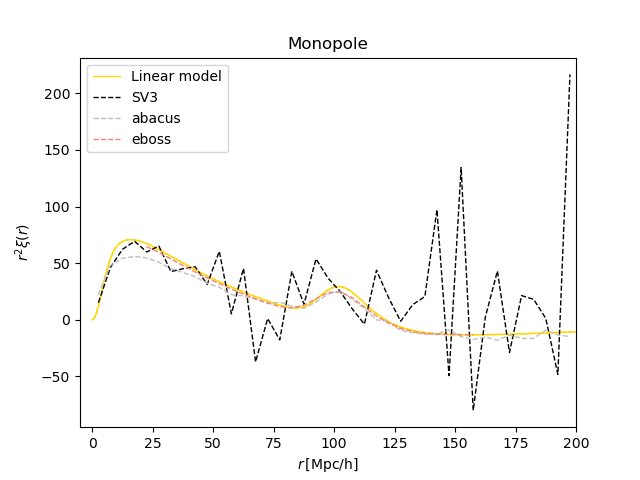

In [28]:
fig, ax = plt.subplots()
pole=0 

Plots.plot_theory(pole, z=1.52, theory=theory_2lpt, ax=ax, rsd=rsd, plot_args=dict(label='Linear model', lw=1, ls='-', c='gold'))
for survey in [realdata, abacus, eboss]:
    ax.plot(survey.r, survey.r**2*survey.compute_npole(pole), label=str(survey), c=survey.color, ls='--', lw=1)
# ax.plot(realdata.r, realdata.r**2*realdata.compute_npole(pole), label='SV3', c='k', ls='--', lw=1)
# ax.plot(abacus.r, abacus.r**2*abacus.compute_npole(pole), c='silver', ls='--', lw=1, label='abacus')
# ax.plot(eboss.r, eboss.r**2*eboss.compute_npole(pole), c='salmon', ls='--', lw=1, label='eboss')
ax.legend()
ax.set_title('Monopole')
ax.set_xlim(-5, 200)

(-5.0, 200.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
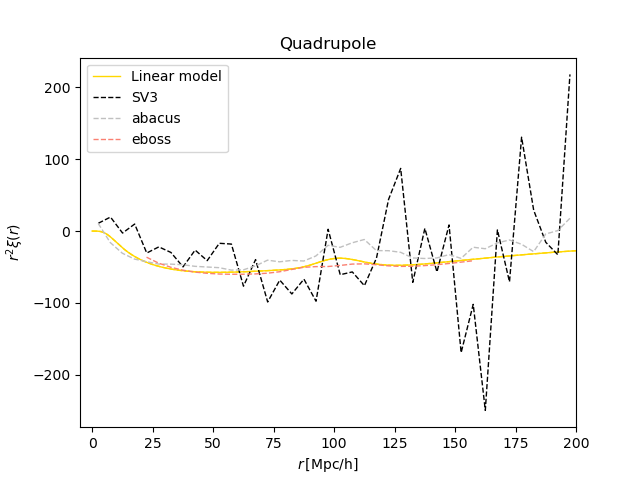

In [29]:
fig, ax = plt.subplots()
pole=2

Plots.plot_theory(pole, z=1.52, theory=theory_2lpt, ax=ax, rsd=rsd, plot_args=dict(label='Linear model', lw=1, ls='-', c='gold'))
for survey in [realdata, abacus, eboss]:
    ax.plot(survey.r, survey.r**2*survey.compute_npole(pole), label=str(survey), c=survey.color, ls='--', lw=1)
# ax.plot(realdata.r, realdata.r**2*realdata.compute_npole(pole), label='SV3', c='k', ls='--', lw=1)
# ax.plot(abacus.r, abacus.r**2*abacus.compute_npole(pole), c='silver', ls='--', lw=1, label='abacus')
# ax.plot(eboss.r, eboss.r**2*eboss.compute_npole(pole), c='salmon', ls='--', lw=1, label='eboss')
ax.legend()
ax.set_title('Quadrupole')
ax.set_xlim(-5, 200)

1 -> (1 +d)^b
2 -> (1+bd) . bd/(1+d)
3 -> (1 +bd) . 0

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
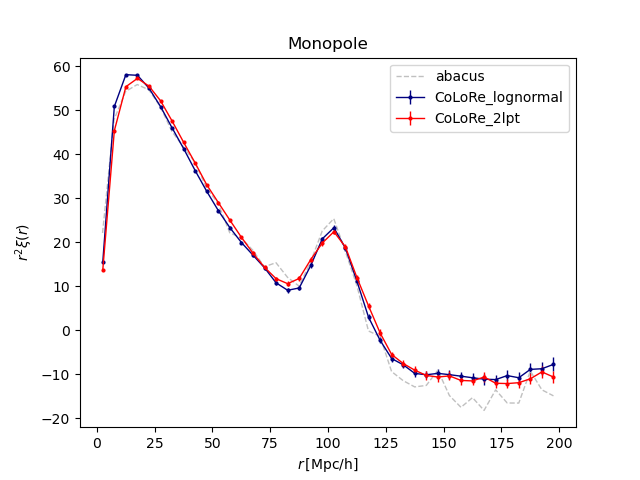

In [30]:
fig, ax = plt.subplots()
pole=0

for analysis in analyses:
    analysis.z = analysis.theory.get_zeff(zmin, zmax)
    Plots.plot_data(pole, analysis.boxes, ax=ax, plot_args=dict(fmt='-', marker='o', markersize=2, lw=1, c=analysis.color, label=str(analysis)))
    
# Plots.plot_theory(pole, z=analysis.z, theory=theory_2lpt, ax=ax, rsd=rsd, plot_args=(label='Linear model', lw=1, ls='-', c='gold'))
for survey in [abacus]:
    ax.plot(survey.r, survey.r**2*survey.compute_npole(pole), label=str(survey), c=survey.color, ls='--', lw=1)

# ax.plot(realdata.r, realdata.r**2*realdata.compute_npole(pole), label='SV3', c='k', ls='--', lw=1)
# ax.plot(abacus.r, abacus.r**2*abacus.compute_npole(pole), c='silver', ls='--', lw=1, label='abacus')
# ax.plot(eboss.r, eboss.r**2*eboss.compute_npole(pole), c='salmon', ls='--', lw=1, label='eboss')
ax.set_title('Monopole')
ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
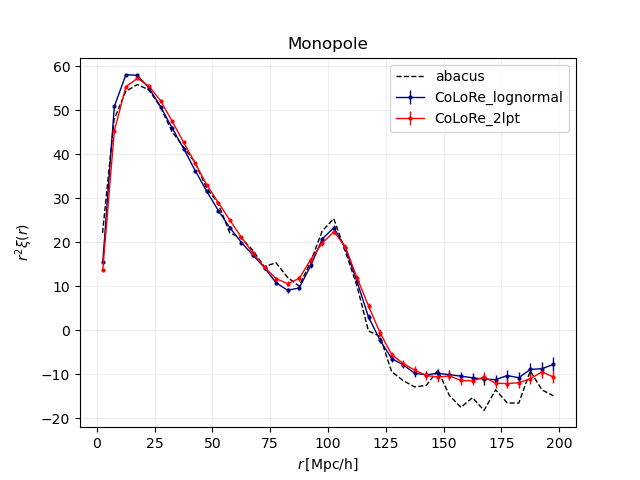

In [44]:
fig, ax = plt.subplots()
pole=0

for analysis in analyses:
    analysis.z = analysis.theory.get_zeff(zmin, zmax)
    Plots.plot_data(pole, analysis.boxes, ax=ax, plot_args=dict(fmt='-', marker='o', markersize=2, lw=1, c=analysis.color, label=str(analysis)))
    
# Plots.plot_theory(pole, z=analysis.z, theory=theory_2lpt, ax=ax, rsd=rsd, plot_args=dict(label='Linear model', lw=1, ls='-', c='gold'))
for survey in [abacus]:
    ax.plot(survey.r, survey.r**2*survey.compute_npole(pole), label=str(survey), c=survey.color, ls='--', lw=1)

# ax.plot(realdata.r, realdata.r**2*realdata.compute_npole(pole), label='SV3', c='k', ls='--', lw=1)
# ax.plot(abacus.r, abacus.r**2*abacus.compute_npole(pole), c='silver', ls='--', lw=1, label='abacus')
# ax.plot(eboss.r, eboss.r**2*eboss.compute_npole(pole), c='salmon', ls='--', lw=1, label='eboss')
ax.set_title('Monopole')
ax.legend()
ax.grid(alpha=0.2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
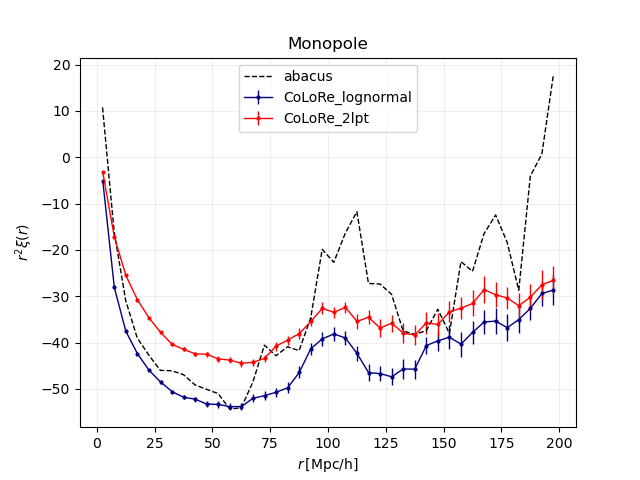

In [45]:
fig, ax = plt.subplots()
pole=2

for analysis in analyses:
    analysis.z = analysis.theory.get_zeff(zmin, zmax)
    Plots.plot_data(pole, analysis.boxes, ax=ax, plot_args=dict(fmt='-', marker='o', markersize=2, lw=1, c=analysis.color, label=str(analysis)))
    
# Plots.plot_theory(pole, z=analysis.z, theory=theory_2lpt, ax=ax, rsd=rsd, plot_args=dict(label='Linear model', lw=1, ls='-', c='gold'))
for survey in [abacus]:
    ax.plot(survey.r, survey.r**2*survey.compute_npole(pole), label=str(survey), c=survey.color, ls='--', lw=1)

# ax.plot(realdata.r, realdata.r**2*realdata.compute_npole(pole), label='SV3', c='k', ls='--', lw=1)
# ax.plot(abacus.r, abacus.r**2*abacus.compute_npole(pole), c='silver', ls='--', lw=1, label='abacus')
# ax.plot(eboss.r, eboss.r**2*eboss.compute_npole(pole), c='salmon', ls='--', lw=1, label='eboss')
ax.set_title('Monopole')
ax.legend()
ax.grid(alpha=0.2)